Importing required libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import rv_discrete
from scipy.stats import geom

Read the trace file

In [52]:
colnames=['arrival_time', 'data_length'] 
df=pd.read_csv("./BC-pAug89.TL",
               sep='\s+', names=colnames)
df.shape

(1000000, 2)

In [53]:
# Number of values to generate in synthetic trace 
# hard-coded in Jupyter Notebook but accepted from cmd line in python file.
n = 1000000

In [54]:
df.head(10)

,arrival_time,data_length
0,0.001340,1090
1,0.001508,174
2,0.004176,162
3,0.008140,174
4,0.011036,162
5,0.015072,174
6,0.017892,162
7,0.020604,150
8,0.022032,174
9,0.024300,90


In [7]:
# To get large figures
sns.set(rc = {'figure.figsize':(50,30)})

<AxesSubplot:xlabel='arrival_time', ylabel='data_length'>

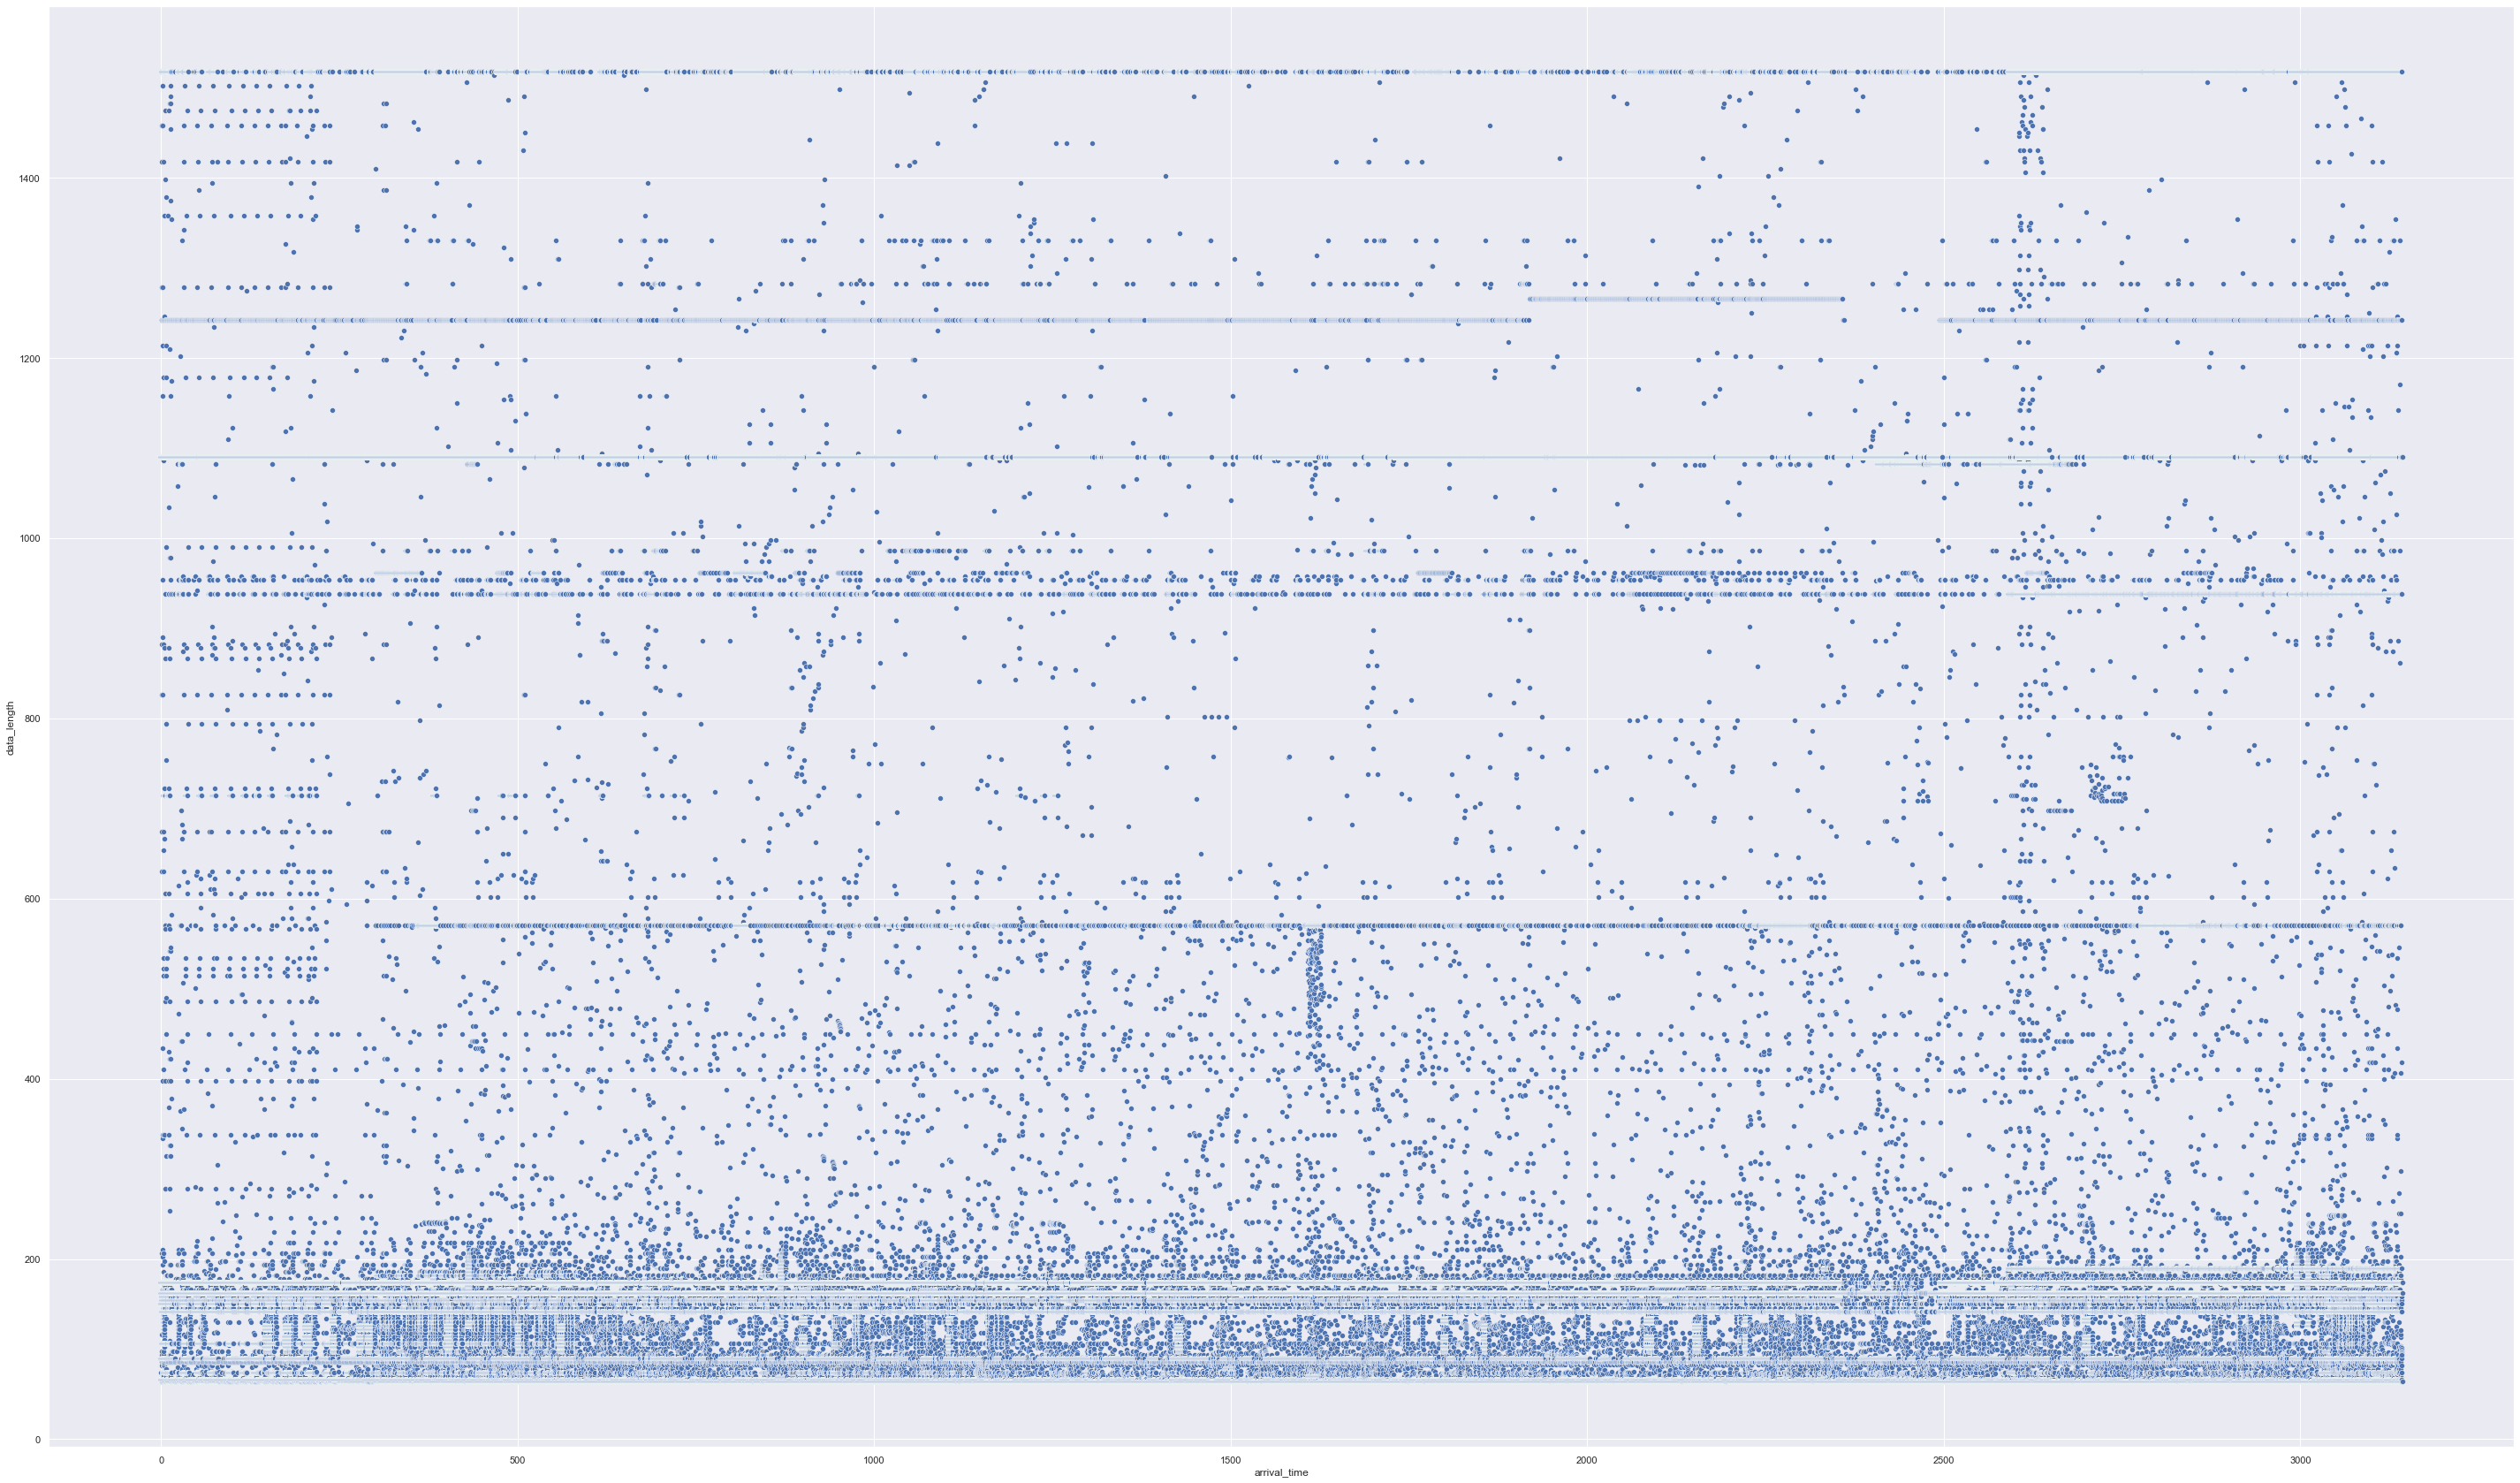

In [60]:
sns.scatterplot(data=df, x="arrival_time", y="data_length")

From the above plot, it looks like packets of smaller length are dense, while packets of larger lengths are sparse. Also, distribution of packet lengths dont vary much with arrival time. Moreover, we can spot some bands of packet lengths where packet density is quite high.

<AxesSubplot:xlabel='data_length'>

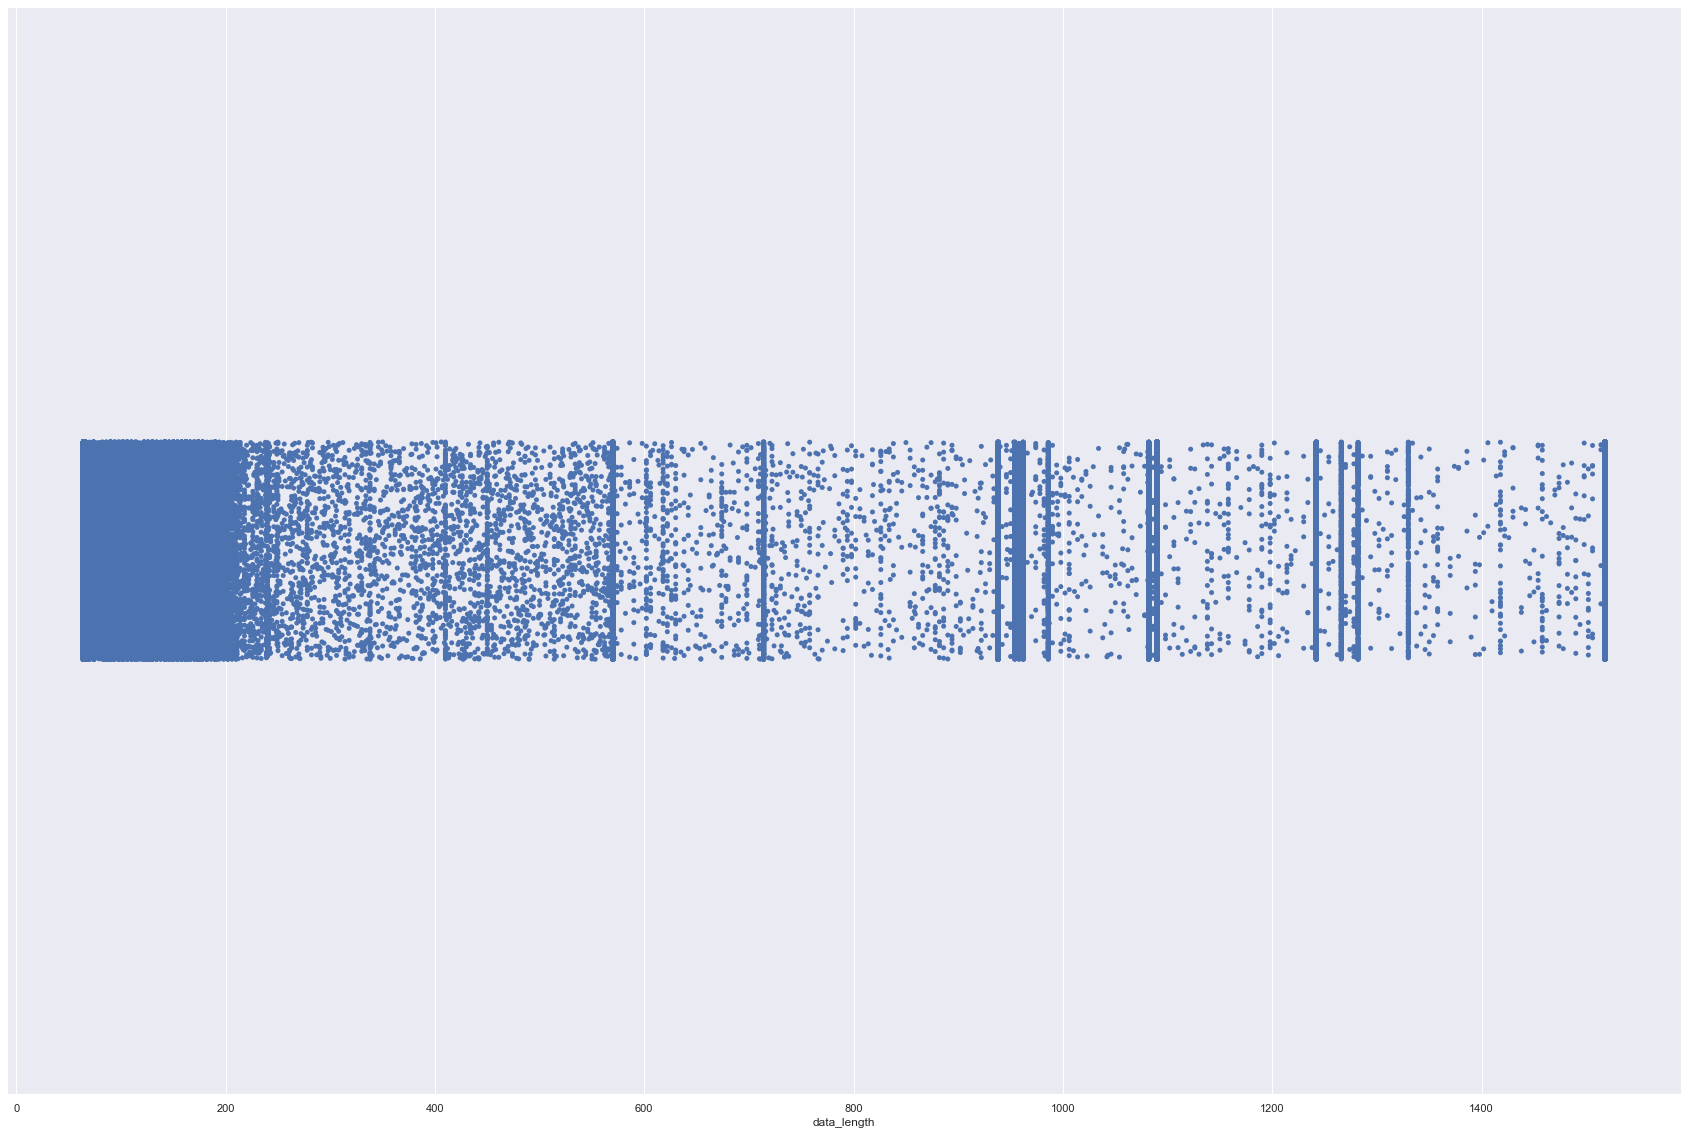

In [61]:
sns.set(rc = {'figure.figsize':(30,20)})
sns.stripplot(x=df["data_length"])

The bands of packet lengths of sizes 1000, 1300 and 1500 approx. shows abnormally more densities. This is perhaps because IEEE 802.3 standards may be forcing some packets to fixed packet lengths. For example, all packets above 1518 bytes are forced to size 1518 bytes. Therefore we see the band at approx 1518.

In [55]:
def binArrivals(arrivals, binSize):
    startTime = 0
    countOfArrivalsInDiscreteTimes = []
    count = 0
    for index, arrivalTime in arrivals.items():
        if arrivalTime < startTime + binSize:
            count += 1
        else:
            countOfArrivalsInDiscreteTimes.append(count)
            startTime = startTime + binSize
            count = 1
    return countOfArrivalsInDiscreteTimes

arrivalCounts_original = binArrivals(df['arrival_time'], 20)

<AxesSubplot:>

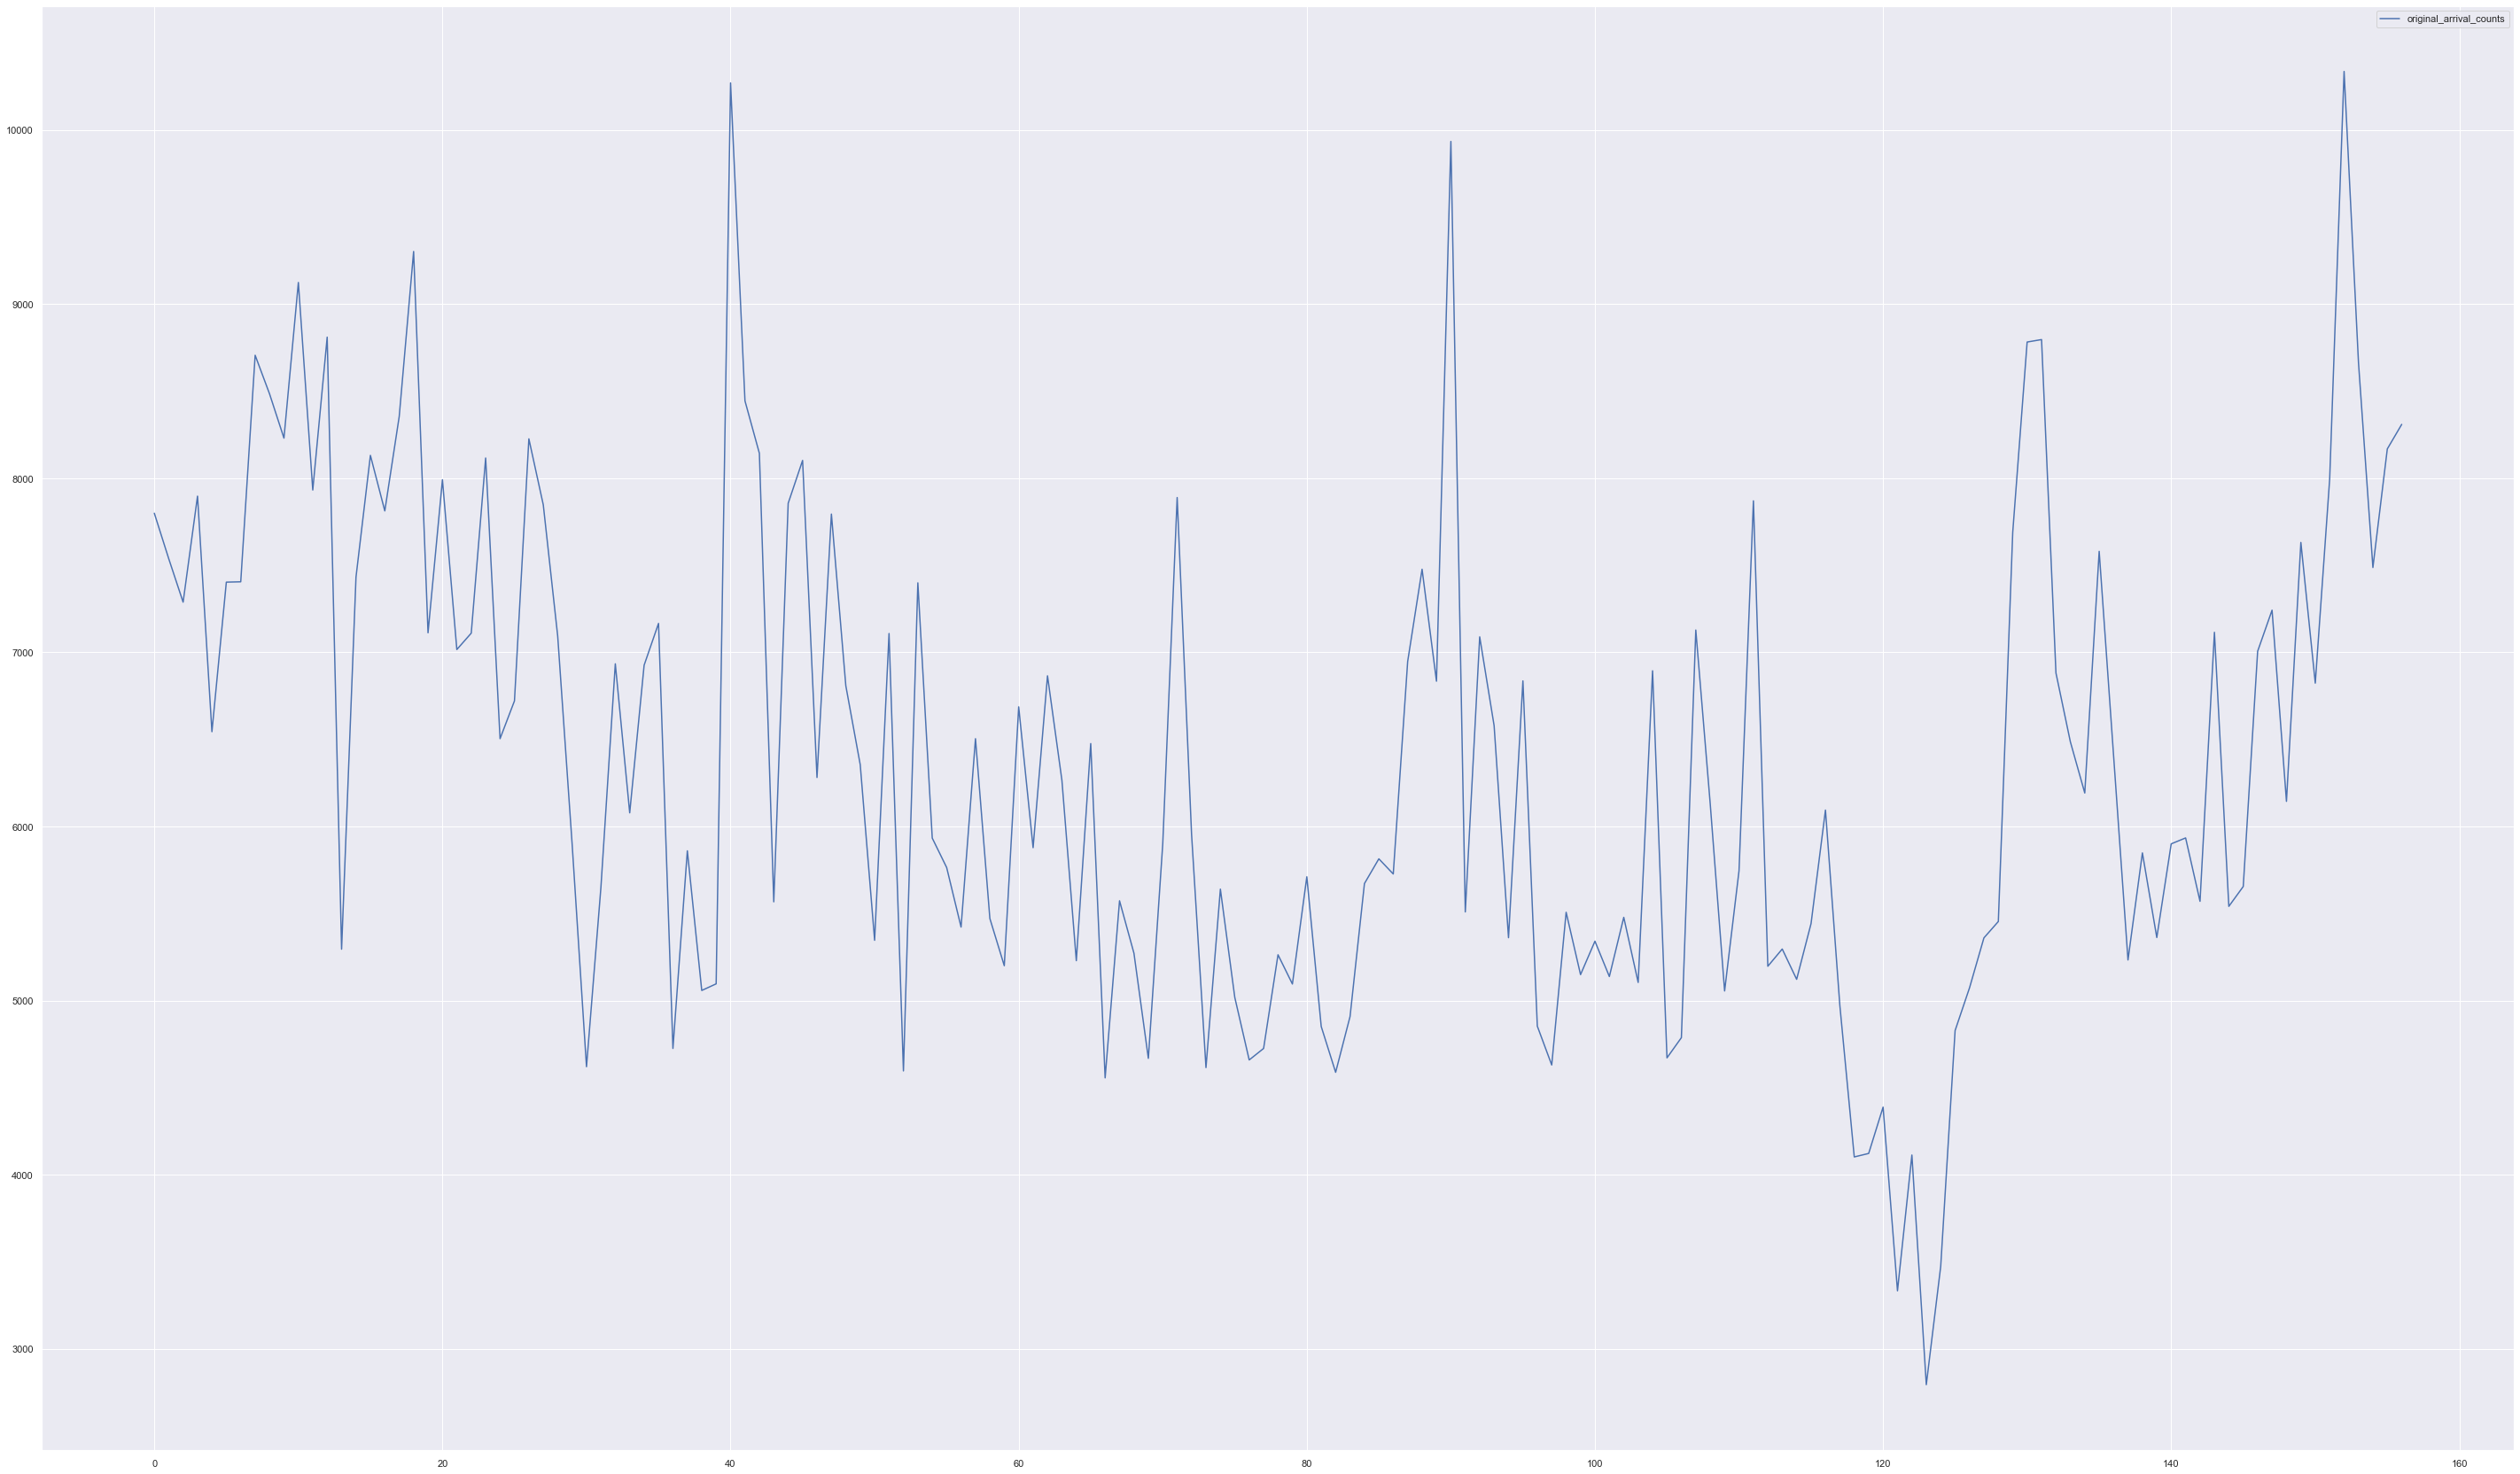

In [10]:
sns.lineplot(data=pd.DataFrame(
    {'original_arrival_counts':arrivalCounts_original}))

The number of arrival are completely random and therefore does not depend on the previous time steps. Let N(t) denotes the number of arrivals at time t, and we have the following times : s1 < t1 < s2 < t2. Then we can say N(t1) - N(s1) is independent of N(t2) - N(s2). The reason is that there is no trend observed in the number of arrivals. Therefore we cannot predict anything about the number of arrivals of any interval given the number of arrivals of a previous interval. So, the arrival proces is likely Poisson.

## Interarrival times

To calculate the interarrival times, we are going to find the difference between the arrival times

In [56]:
interarrival = df['arrival_time'][1:]
interarrival.reset_index(drop=True, inplace=True)
interarrival = interarrival.subtract(df['arrival_time'][:-1])
interarrival

0         0.000168
1         0.002668
2         0.003964
3         0.002896
4         0.004036
5         0.002820
6         0.002712
7         0.001428
8         0.002268
9         0.000452
10        0.002604
11        0.001336
12        0.002148
13        0.000768
14        0.004236
15        0.002624
16        0.004056
17        0.001520
18        0.001280
19        0.001972
20        0.001952
21        0.001112
22        0.001824
23        0.001636
24        0.002536
25        0.002688
26        0.003984
27        0.002872
28        0.004132
29        0.002728
            ...   
999969    0.001252
999970    0.001224
999971    0.001212
999972    0.001224
999973    0.001104
999974    0.000192
999975    0.001420
999976    0.001632
999977    0.000268
999978    0.000064
999979    0.000952
999980    0.003088
999981    0.002756
999982    0.002788
999983    0.001452
999984    0.002616
999985    0.001220
999986    0.003000
999987    0.002640
999988    0.004400
999989    0.002460
999990    0.

In [57]:
interarrival.describe()

count    999999.000000
mean          0.003143
std           0.005643
min           0.000020
25%           0.001108
50%           0.001956
75%           0.003760
max           0.341936
Name: arrival_time, dtype: float64

In [58]:
mean = np.mean(interarrival)
print("mean of interarrival times of original distribution",mean)
variance = np.std(interarrival) ** 2
print("variance of interarrival times of original distribution",variance)

mean of interarrival times of original distribution 0.003142823538823539
variance of interarrival times of original distribution 3.184068014741052e-05


In [59]:
print("Mean squarred ", mean**2)

Mean squarred  9.877339796183313e-06


We can see that the variance of the interval times is not equal to the mean^2 as we expect if the arrival times are from a poisson process.

In [60]:
interarrival_df = interarrival.to_frame(name="inter-arrivals")

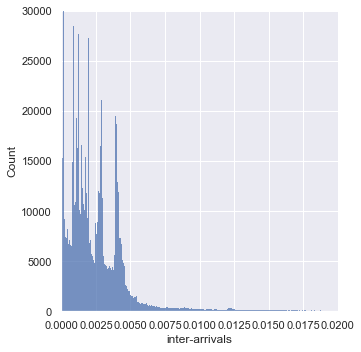

In [61]:
displot = sns.displot(interarrival_df, x="inter-arrivals")
displot.set(ylim = (0, 30000))
displot.set(xlim = (0, 0.02))

However, its still clear that the interarrival times are exponentially distributed with some spikes at specific values of interarrival time. These spikes are the reason why variance is higher than what we would expect in a poisson distribution.

<bound method Axes.plot of <AxesSubplot:xlabel='inter-arrivals', ylabel='Proportion'>>

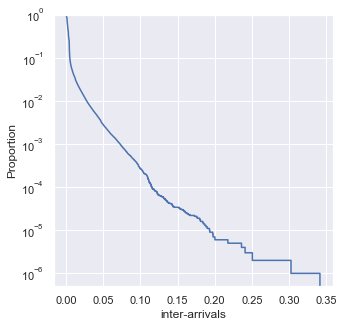

In [67]:
sns.set(rc = {'figure.figsize':(5,5)})
g = sns.ecdfplot(interarrival_df, x="inter-arrivals", complementary=True)
g.set(yscale="log")
g.plot

The above plot shows the probability P(X>x) in log scale for interarrival times.

## Synthetic Trace

For generating the interarrival times, we will use the poisson distribution. Moreover, we will tune lambda such that the 1st and 2nd moment of interarrival times of the synthetic trace is as close to the original as possible.

In [62]:
lmbda_max = 1/mean
print(lmbda_max)
std_div = np.std(interarrival)
lmbda_min = (1/std_div)
print(lmbda_min)

318.1852202794473
177.21840844432785


We want to find a value of lamda that is somewhere inbetween 177 and 318, such that it minimizes the difference in mean and variance between the original and synthetic trace.

In [63]:
'''
We are computing a function 
f(x) = |(variance - 1/lmbda^2)*variance_weight + (mean - 1/lmbda)|
We want that value of lmbda for which f(x) is minimum. 
This value of lmbda minimizes the error in variance and mean in the 
synthetic distribution.
'''
d = {}
# since variance is much smaller than mean we need to use a weight 
# so that the minimization will reduce both mean and variance.
variance_weight = 15
for i in range(math.floor(lmbda_min), math.floor(lmbda_max) + 1):
    # i is a lmbda value
    var_delta = variance - 1/(i**2)
    var_delta = var_delta * variance_weight
    mean_delta = mean - 1/i
    value = mean_delta + var_delta
    d[i] = abs(value)

# Find the value of lmbda which minimizes f(x)
min_lmbda = 0
min_value = 1000
for key in d:
    if d[key] < min_value:
        min_value = d[key]
        min_lmbda = key

lmbda = min_lmbda
lmbda

290

In the above calculation, we are using some variance_weight to increase the importance of variance in the minimization task. Otherwise, the minimization would just choose a value of lambda that minimizes mean. However, we don't want to give too much importance to the variance as using the poisson distribution we won't be able to model the spikes which are present in the exponential distribution of inter-arrival times in the original trace. The spikes are the reason for the majority of the variance.

So, for our synthetic distribution, we are choosing the value of lambda as calculated. We will model the arrival times as poisson distribution using this value of lambda.

In [64]:
synthetic_mean = 1/lmbda
synthetic_variance = (1/lmbda)**2
print("synthetic mean ", synthetic_mean)
print("synthetic variance ", synthetic_variance)

synthetic mean  0.0034482758620689655
synthetic variance  1.1890606420927467e-05


In [65]:
def exponential_inverse_transform(mean, n):
    uniform_random = np.random.random(n)
    arrival_times = -np.log(1-uniform_random) * mean
    return arrival_times

synthetic_interarrival_times = exponential_inverse_transform(synthetic_mean, n)

## Percentage error in mean and variance from original trace 

In [66]:
def errorInPercent(original, evaluated):
    return abs(original - evaluated) / original * 100

error_mean = errorInPercent(mean, np.mean(synthetic_interarrival_times))
error_mean

9.94563336530603

In [67]:
error_variance = errorInPercent(variance, np.var(synthetic_interarrival_times))
error_variance

62.558611154270416

In [68]:
synthetic_interarrival_times_df = pd.DataFrame(
    synthetic_interarrival_times, columns=['inter-arrivals'])

[(0.0, 0.02)]

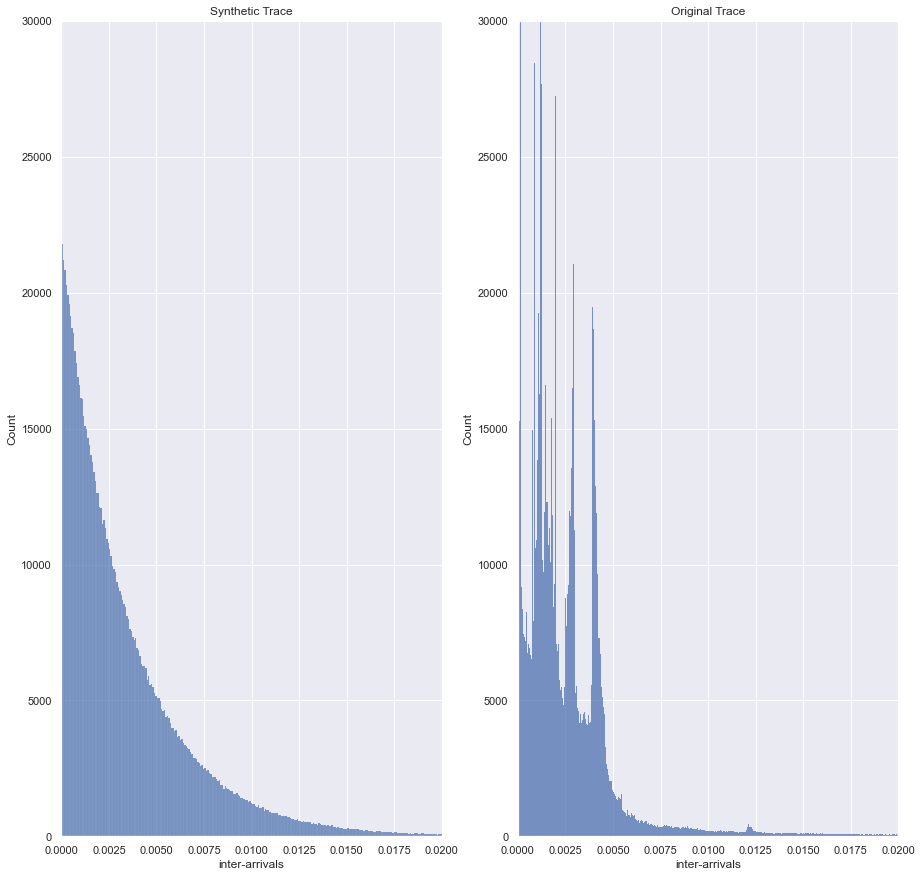

In [69]:
sns.set(rc = {'figure.figsize':(15,15)})

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes.flat[0]
ax2 = axes.flat[1]
ax1.title.set_text('Synthetic Trace')
ax2.title.set_text('Original Trace')
histplot = sns.histplot(synthetic_interarrival_times_df,ax=ax1,x="inter-arrivals")
histplot.set(ylim = (0, 30000))
histplot.set(xlim = (0, 0.02))

histplot = sns.histplot(interarrival_df,ax=ax2,x="inter-arrivals")
histplot.set(ylim = (0, 30000))
histplot.set(xlim = (0, 0.02))

In [70]:
synthetic_interarrival_times_df.describe()

,inter-arrivals
count,1.000000e+06
mean,3.455397e-03
std,3.452768e-03
min,1.570899e-09
25%,9.933057e-04
50%,2.397308e-03
75%,4.792431e-03
max,5.369487e-02


In [71]:
time = 0
arrival_times = []
for index, value in synthetic_interarrival_times_df['inter-arrivals'].items():
    time += value
    arrival_times.append(time)

In [72]:
arrivalCounts_synthetic = binArrivals(pd.Series(arrival_times), 20)

### Lets plot the total number of arrivals every 20s in the original trace and the synthetic trace together to see how good the synthetic trace fits the original.

<AxesSubplot:>

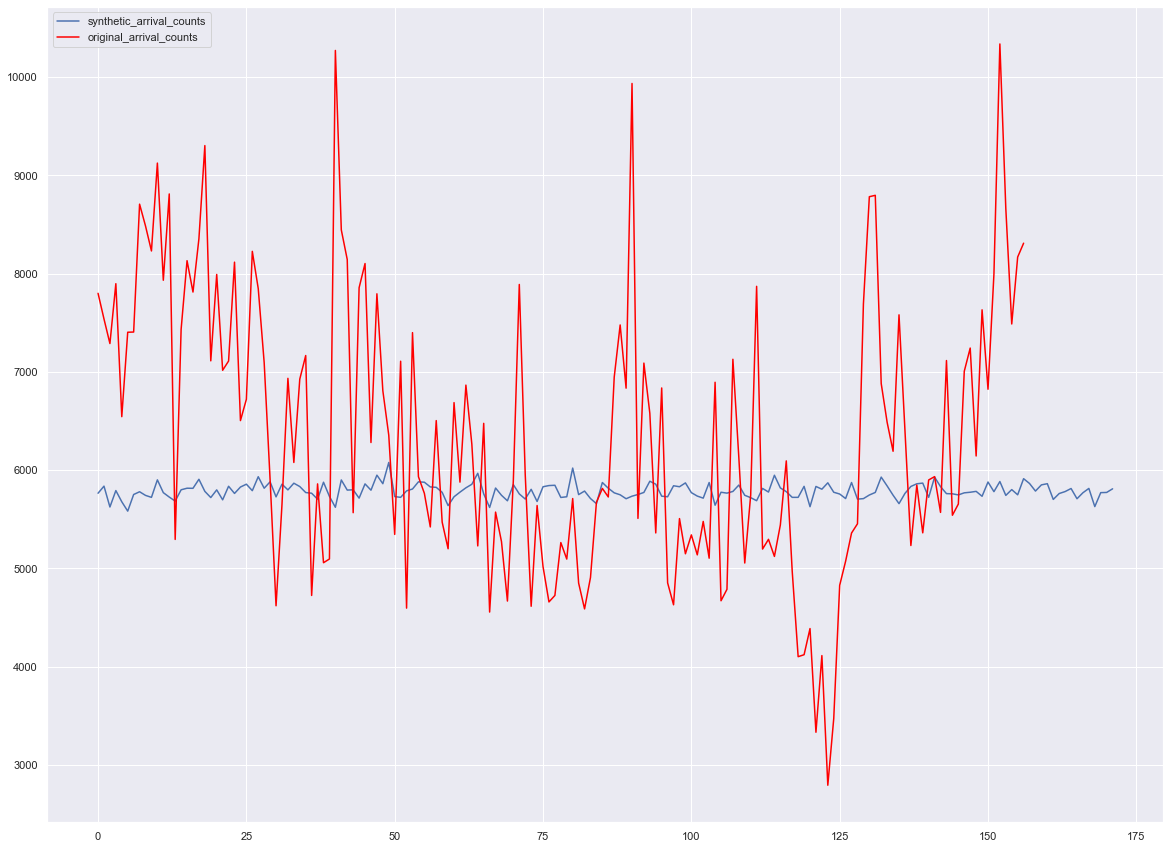

In [73]:
sns.set(rc = {'figure.figsize':(20,15)})
sns.lineplot(data=pd.DataFrame(
    {'synthetic_arrival_counts':arrivalCounts_synthetic}
))
sns.lineplot(data=pd.DataFrame(
    {'original_arrival_counts':arrivalCounts_original}),
             palette=['red'])

Although we could model the mean accurately, we are unable to explain the variance equally well. However, from the plot of the original trace, it appears to me that most of the variance is due to spikes which are mostly random / noise.

# Model Packet Lengths

In [138]:
df["data_length"].describe()

count    400000.000000
mean        464.097850
std         406.935392
min          64.000000
25%         138.000000
50%         332.000000
75%         666.000000
max        1522.000000
Name: data_length, dtype: float64

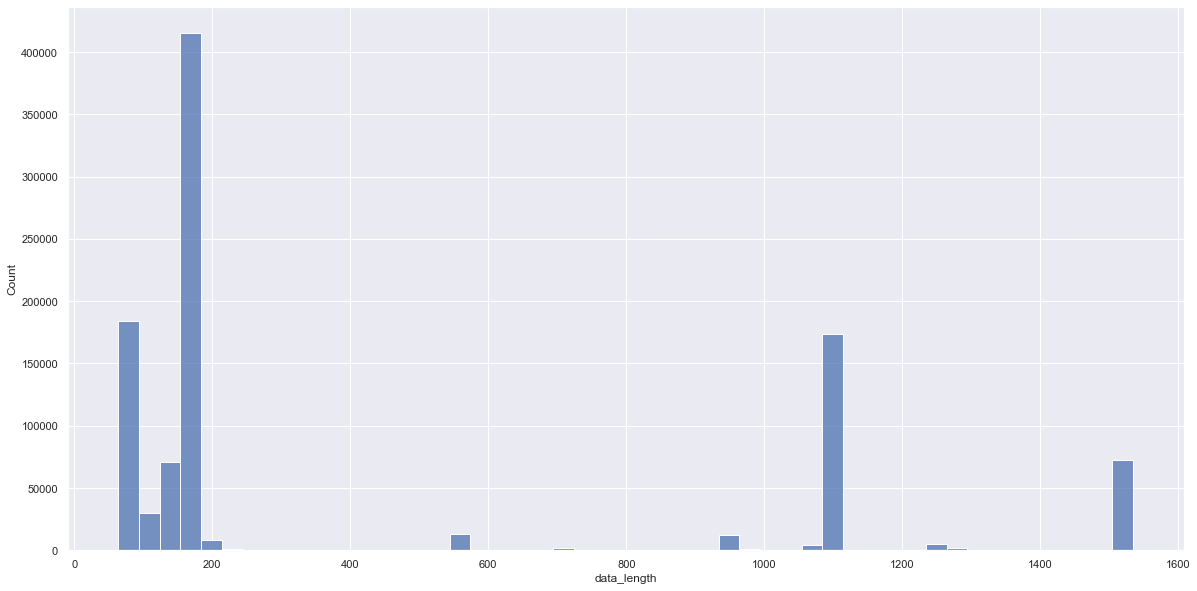

In [101]:
sns.set(rc = {'figure.figsize':(20,10)})
hisplot = sns.histplot(df, x="data_length",binwidth=30)

In [102]:
df["data_length"].head(30)

0     1090
1      174
2      162
3      174
4      162
5      174
6      162
7      150
8      174
9       90
10     162
11     150
12     174
13      90
14     162
15     174
16     162
17     174
18     150
19     162
20      90
21     174
22     150
23     162
24      90
25     174
26     162
27     174
28     162
29     174
Name: data_length, dtype: int64

# Model packet lengths using standard geometric distribution

Looking at the packet size distribution (pmf), it looks quite similar to exponential. However, to model it using a discrete probability distribution, I found the geometric distribution (pmf) to be the most fitting.

## Find "p" which reduces both mean and variance error.

In a perfect geometric distribution we can choose the value of p as 1/mean of the distribution. However, this will result in large variance error. Lets calculate the variance error when p = 1/mean. After that we will try to tune p.

In [103]:
p = 1 / df["data_length"].mean()
p

0.002302598087506699

Now, we will generate random values from the geometric distribution with the p we calculated above

In [104]:
def generateRandomValuesFromGeometricDistribution(p, n):
    geometric_model = geom(p)
    packet_lengths = geometric_model.rvs(size=n)
    l = []
    # As per problem statement, packet lengths less than 
    # 64 bytes and more than 1522 bytes are not allowed according 
    # to IEEE standards. So we force packet sizes below 64 bytes 
    # to 64 bytes and above 1522 bytes to 1522 bytes. This is justified 
    # as we can see that at 64 and 1522 bytes, the packet density 
    # is quite high in the original trace.
    
    for packet_length in packet_lengths:
        if packet_length < 64:
            l.append(64)
        elif packet_length > 1522:
            l.append(1522)
        else:
            l.append(packet_length)

    return l
    

packet_sizes = generateRandomValuesFromGeometricDistribution(p,n)

In [105]:
var_synthetic = np.var(packet_sizes)
errorInPercent(np.var(df["data_length"]), var_synthetic)

38.34178035687942

To reduce both mean and variance error, we will try to minimize the following function:

f = |(Original trace variance) - (Synthetic trace variance)| + |(Original trace mean) - (Synthetic trace mean)|

Its easy to argue variance in original trace would be greater than variance in synthetic trace as synthetic trace does not contain noise. However, looking at the original trace we can infer that mean of original trace would be lesser than the synthetic trace. This is because most packets in the original trace has small sizes but in the synthetic trace it would be more evenly distributed compared to the original trace.

Synthetic trace mean = 1/p
Synthetic trace variance = (1-p) / p^2

If we try to find the value of p which gets f near to zero, we will have:
p = 1 / 1 + sqrt(V - nE + 1)

Note, we need to multiply mean with a weight in the minimization problem as mean is much smaller than variance.

In [137]:
def calculateValueOfP(mean, standard_deviation):
    # After trying out different values of n, we found n=15
    # does a good job in minimizing both mean and variance errors.
    n = 15
    variance = standard_deviation**2
    total = variance - mean*n + 1 # its important that n*mean does 
                                  # not exceed variance.
    sqrt = total ** (1/2) + 1
    value = 1 / sqrt
    return value

mean_of_original_trace = df["data_length"].mean()
std_of_original_trace = df["data_length"].std()
p = calculateValueOfP(mean_of_original_trace, std_of_original_trace)
p

0.0025044373459980037

In [107]:
synthetic_packet_sizes = generateRandomValuesFromGeometricDistribution(p,n)
var_synthetic = np.var(synthetic_packet_sizes)
mean_synthetic = np.mean(synthetic_packet_sizes)
print("Mean of synthetic ", mean_synthetic)
print("Variance of synthetic ", var_synthetic)
print("variance error % ", errorInPercent(np.var(df["data_length"]), var_synthetic))
print("mean error % ", errorInPercent(df["data_length"].mean(), mean_synthetic))

Mean of synthetic  463.269121
Variance of synthetic  164544.63355288733
variance error %  30.039995128274654
mean error %  6.672259201550943


Clearly, the minimization helped to reduce variance error at the expense of some additional error in mean.

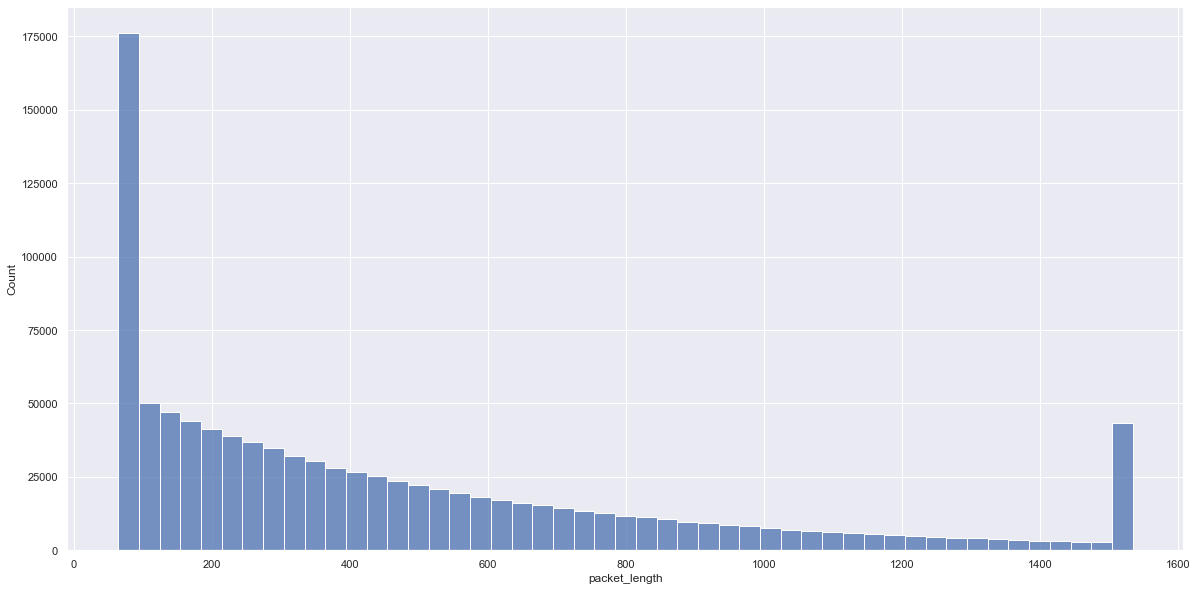

In [108]:
synthetic_packet_length_df = pd.DataFrame(data=synthetic_packet_sizes,
                                          columns=["packet_length"])
hisplot = sns.histplot(pd.DataFrame(data=synthetic_packet_length_df),
                       binwidth=30, x = "packet_length")

# Model packet lengths using empirical distribution [ALTERNATE APPROACH]

In this strategy, we do not use any standard distribution. We sample the synthetic packet lengths from the original packet length distribution. The reason is that, we believe IEEE standards and other network protocols allow only specific packet sizes and the original discrete distribution can be re-used for the synthetic distribution. Out of 1 million random data points, since there are none for some packet lengths, it is perhaps logical to assume that the reason is restrictions imposed by the network infrastructure.

In [121]:
packet_length_probabilities = {}

for i in range(64, 1519):
    packet_length_probabilities[i] = 0

for i in df["data_length"]:
    packet_length_probabilities[i] = packet_length_probabilities[i] + 1

total_packets = len(df["data_length"])
for key in packet_length_probabilities:
    packet_length_probabilities[key] /= total_packets


In [122]:
packet_lengths = list(packet_length_probabilities.keys())
packet_probabilities = list(packet_length_probabilities.values())
packet_length_df = pd.DataFrame({'Packet Size':packet_lengths, 
                                 'Percentage': packet_probabilities})

Text(0, 0.5, 'Probability')

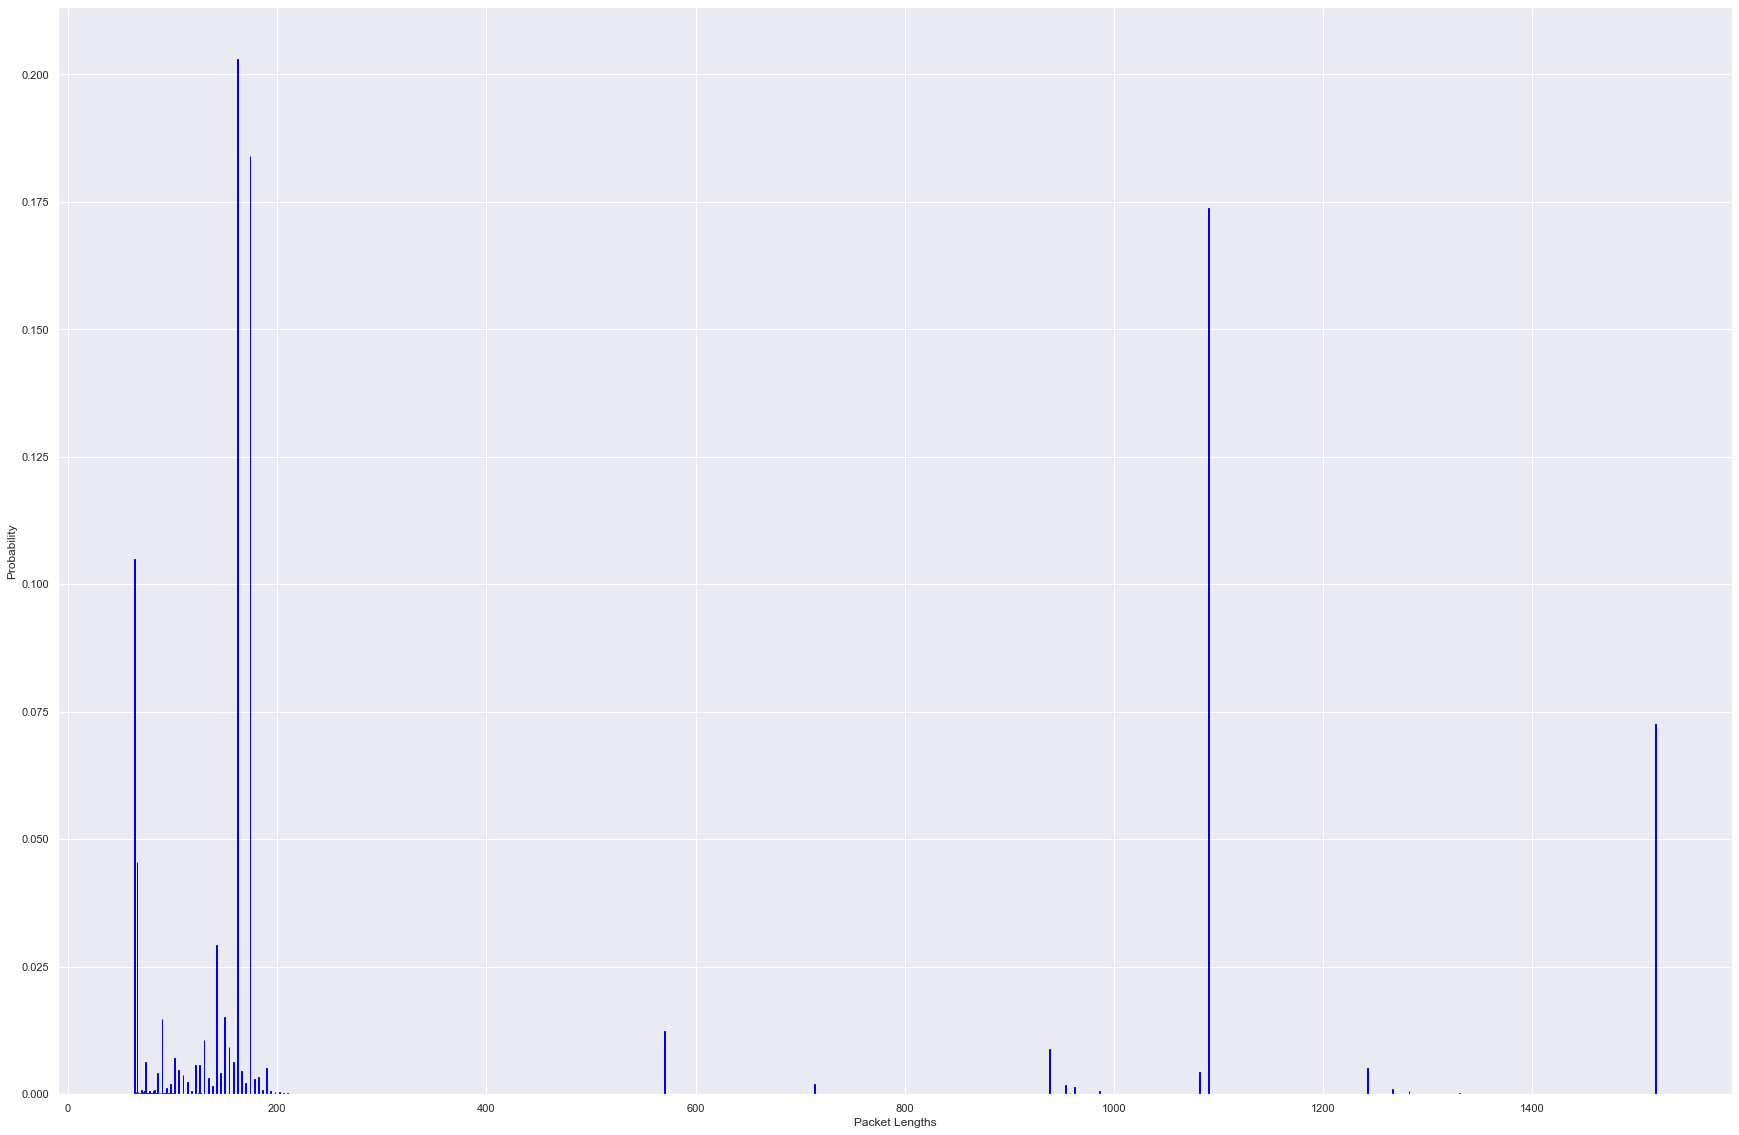

In [123]:
plt.bar(packet_lengths, packet_probabilities, color=(0.1, 0.1, 0.1, 0.1),
        edgecolor='blue')
plt.xlabel("Packet Lengths")
plt.ylabel("Probability")

Clearly, we can observe that only certain packet lengths have packet densities, other lengths have zero densities. Also, we can observe that certain packet lengths have more densities than others.

We can clearly see that the packet lengths are discrete (integers).

## Generating synthetic packet lengths

We use the discrete probability distribution that we generated above to create the synthetic packet lengths. The intuition behind this is, IEEE standards allows only specific packet sizes. Moreover, some packet lengths are denser because IEEE standards forces packets to specific sizes. To ensure we preserve exact packet size, we are using the same distribution as was in the original trace.

In [124]:
discrete_packets_model = rv_discrete(values=(packet_lengths, packet_probabilities))
synthetic_packet_lengths = discrete_packets_model.rvs(size=n)
print("Total synthetic packet lengths ",len(synthetic_packet_lengths))

Total synthetic packet lengths  1000000


In [125]:
synthetic_packet_lengths

array([174, 174,  66, ...,  66,  64, 142])

In [126]:
synthetic_packet_length_df = pd.DataFrame(data=synthetic_packet_lengths,
                                          columns=["packet_length"])

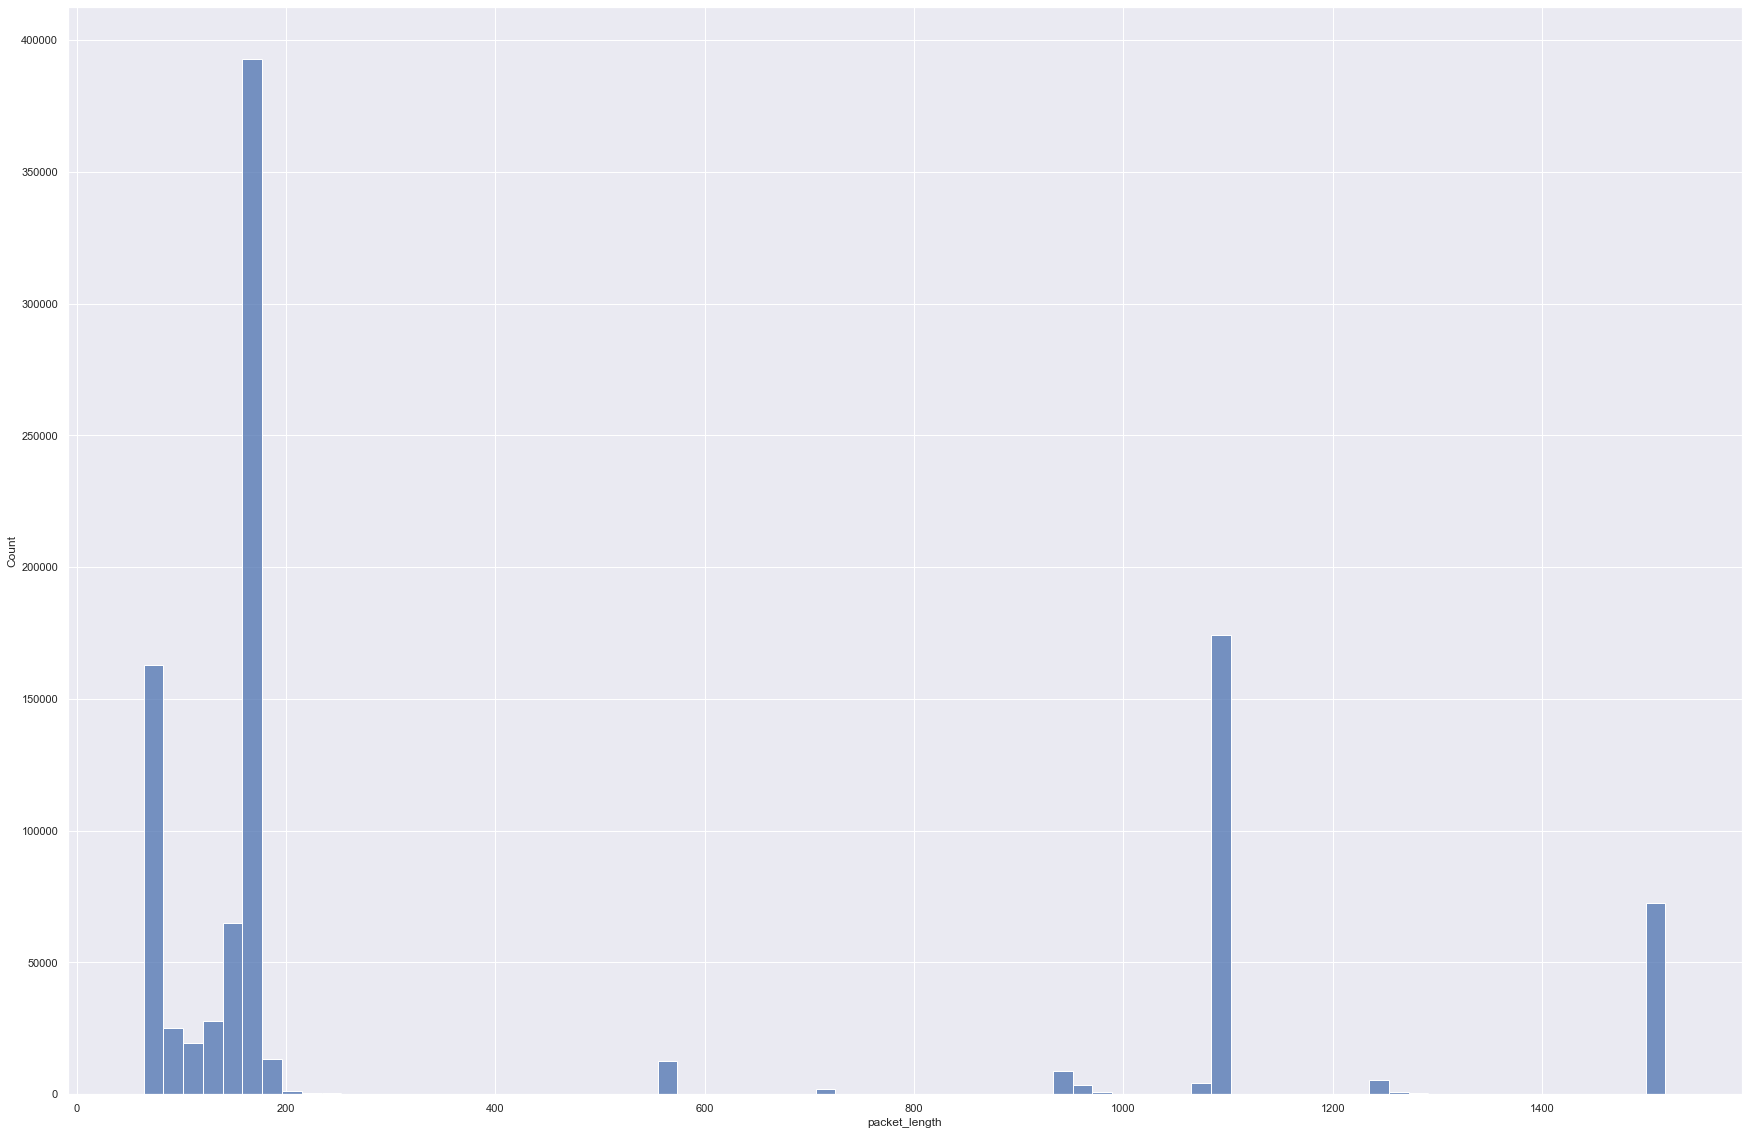

In [127]:
hisplot = sns.histplot(synthetic_packet_length_df, x = "packet_length")

In [128]:
synthetic_packet_length_df.describe()

,packet_length
count,1000000.000000
mean,434.821350
std,485.160341
min,64.000000
25%,142.000000
50%,162.000000
75%,1090.000000
max,1518.000000


## Percentage error in Mean and Variance in packet lengths

In [129]:
synthetic_packet_length_mean = synthetic_packet_length_df["packet_length"].mean()
synthetic_packet_length_mean

434.82135

In [130]:
print("error in mean % ",errorInPercent(
    df["data_length"].mean(), 
    synthetic_packet_length_df["packet_length"].mean()))

error in mean %  0.1218808917080928


In [131]:
print("error in variance % ",errorInPercent(
    df["data_length"].std()**2, 
    synthetic_packet_length_df["packet_length"].std()**2))

error in variance %  0.07745650272663085


### Lets plot the packet lengths in the original trace and the synthetic trace together to see how good the synthetic trace fits the original.¶

<AxesSubplot:xlabel='packet_length'>

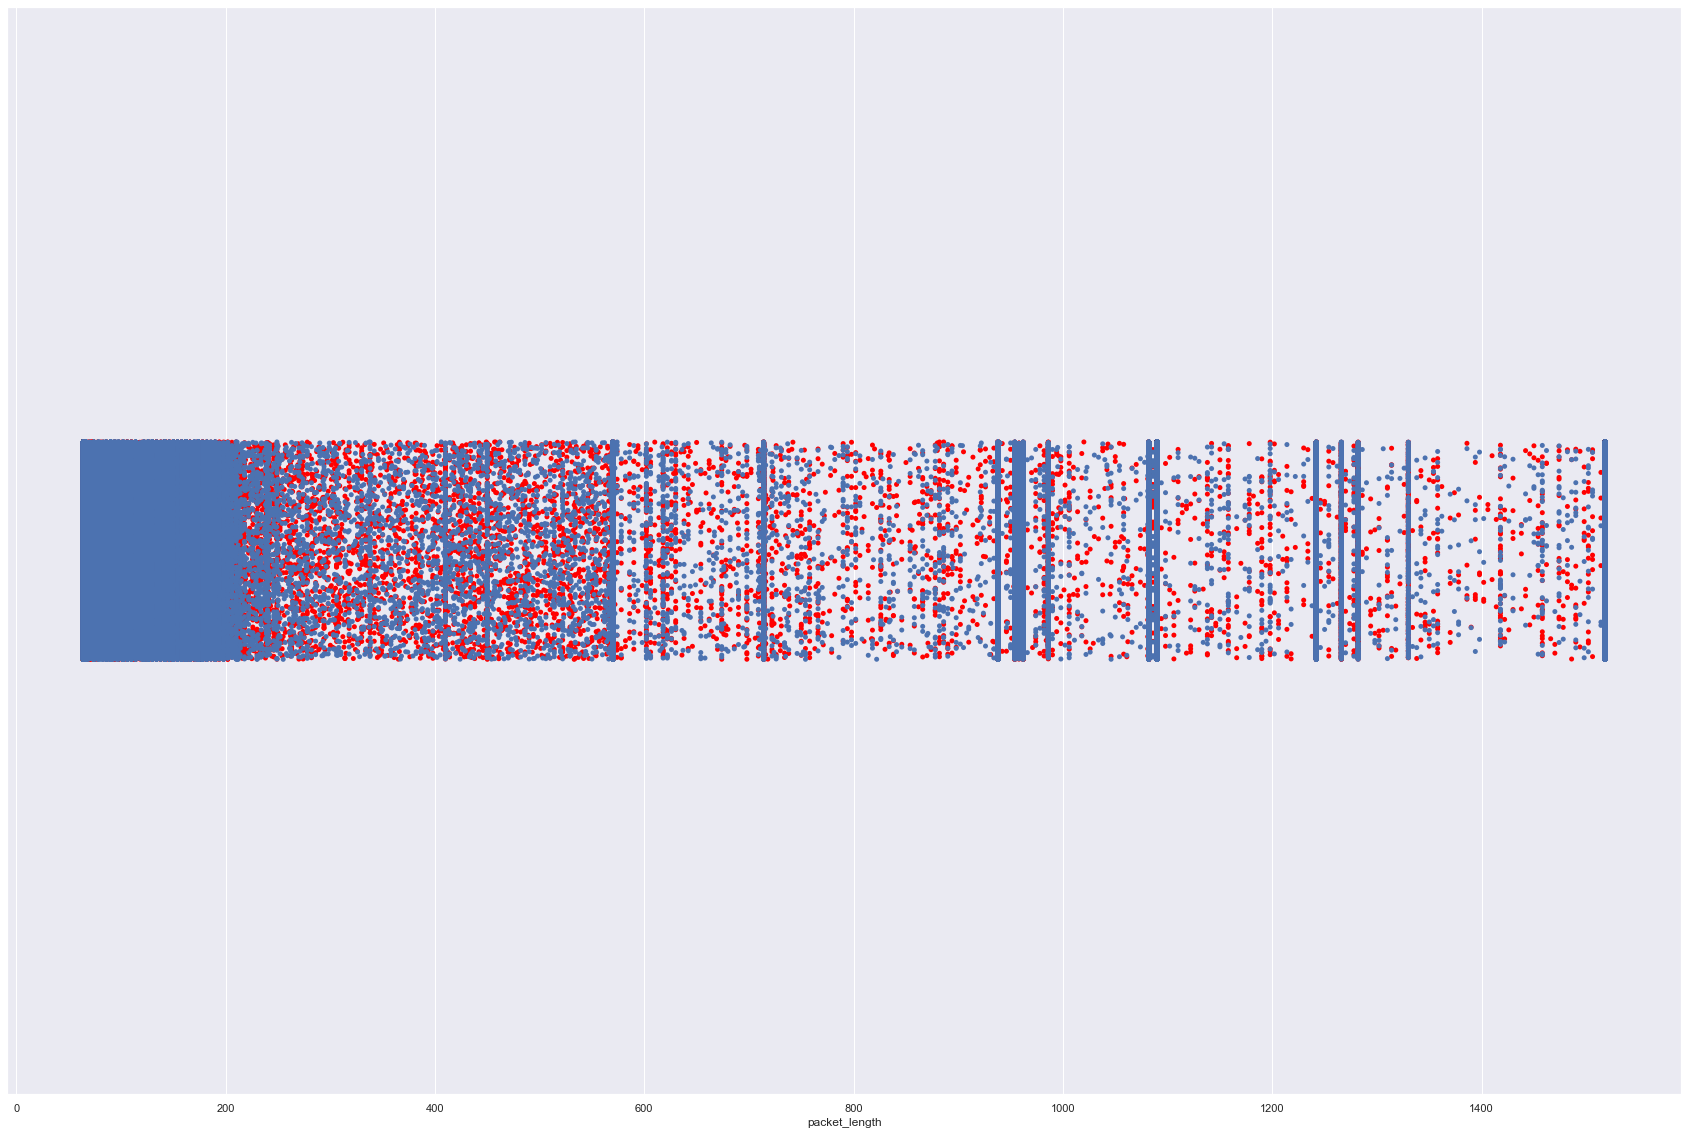

In [132]:
sns.set(rc = {'figure.figsize':(30,20)})
sns.stripplot(x=df["data_length"], palette=['red'])
sns.stripplot(x=synthetic_packet_length_df["packet_length"])